In [1]:
import snowflake.connector
import pandas
import torch
from interactions import Interactions
from cross_validation import random_train_test_split

In [2]:
import snowflake.connector
import pandas as pd

def create_connection():
    ctx = snowflake.connector.connect(
        user='Zan',
        password='Kundalini55!',
        account='livenpay.ap-southeast-2')
    return ctx

def setup_snowflake(cursor):
    cursor.execute("use warehouse zans_wh")
    cursor.execute("use zans_db.postgres")
    
def query(cursor,query):
    cursor.execute(query)
    results = cursor.fetchall()
    return results

timestamped_sql = """
SELECT 
	accountcoupon_couponusehistory.time AS "accountcoupon_couponusehistory.time",
	account_localuser.id  AS "account_localuser.id",
	account_localuser.email  AS "account_localuser.email",
	merchant_merchant.name  AS "merchant_merchant.name",
	case when merchant_merchant.membership_zone_id = 1 then 'Melbourne'
    when merchant_merchant.membership_zone_id = 2 then 'Sydney'
    else null end AS "merchant_merchant.city",
	branch_branch.id  AS "branch_branch.id",
	branch_branch.suburb_id  AS "branch_branch.suburb_id"
FROM account_localuser AS account_localuser
LEFT JOIN accountcoupon_couponusehistory  AS accountcoupon_couponusehistory ON account_localuser.id = accountcoupon_couponusehistory.user_id 
LEFT JOIN branch_branch  AS branch_branch ON accountcoupon_couponusehistory.branch_id = branch_branch.id 
LEFT JOIN merchant_merchant  AS merchant_merchant ON merchant_merchant.id = branch_branch.merchant_id 

WHERE ((CASE WHEN account_localuser.is_staff  THEN 1 ELSE 0 END
) = 0) AND ((CASE
    WHEN DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE())) is not null
    AND DATEADD('month', 12, DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE()))) is not null /* date ranges or in the past x days */
    THEN
    CASE
    WHEN accountcoupon_couponusehistory.time >=  TO_TIMESTAMP(DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE())))
    AND accountcoupon_couponusehistory.time <= TO_TIMESTAMP(DATEADD('month', 12, DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE()))))
    THEN 'This Period'
    WHEN accountcoupon_couponusehistory.time >=
    DATEADD('day',
      DATEDIFF('day',
        TO_TIMESTAMP(DATEADD('month', 12, DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE())))),
        TO_TIMESTAMP(DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE())))
      )*-1,
      DATEADD('day', -1,
        TO_TIMESTAMP(DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE())))
      )
    )
    AND accountcoupon_couponusehistory.time <= TO_TIMESTAMP(DATEADD('day', 1,DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE()))))
    THEN 'Previous Period'
    END
    END
) IS NOT NULL
)
GROUP BY 7,1,2,3,4,5,6
ORDER BY 1 DESC
"""

sql = """
SELECT 
	account_localuser.id  AS "account_localuser.id",
	account_localuser.email  AS "account_localuser.email",
	merchant_merchant.name  AS "merchant_merchant.name",
	case when merchant_merchant.membership_zone_id = 1 then 'Melbourne'
    when merchant_merchant.membership_zone_id = 2 then 'Sydney'
    else null end AS "merchant_merchant.city",
	branch_branch.id  AS "branch_branch.id",
	branch_branch.suburb_id  AS "branch_branch.suburb_id"
FROM account_localuser AS account_localuser
LEFT JOIN accountcoupon_couponusehistory  AS accountcoupon_couponusehistory ON account_localuser.id = accountcoupon_couponusehistory.user_id 
LEFT JOIN branch_branch  AS branch_branch ON accountcoupon_couponusehistory.branch_id = branch_branch.id 
LEFT JOIN merchant_merchant  AS merchant_merchant ON merchant_merchant.id = branch_branch.merchant_id 

WHERE ((CASE WHEN account_localuser.is_staff  THEN 1 ELSE 0 END
) = 0) AND ((CASE
    WHEN DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE())) is not null
    AND DATEADD('month', 12, DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE()))) is not null /* date ranges or in the past x days */
    THEN
    CASE
    WHEN accountcoupon_couponusehistory.time >=  TO_TIMESTAMP(DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE())))
    AND accountcoupon_couponusehistory.time <= TO_TIMESTAMP(DATEADD('month', 12, DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE()))))
    THEN 'This Period'
    WHEN accountcoupon_couponusehistory.time >=
    DATEADD('day',
      DATEDIFF('day',
        TO_TIMESTAMP(DATEADD('month', 12, DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE())))),
        TO_TIMESTAMP(DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE())))
      )*-1,
      DATEADD('day', -1,
        TO_TIMESTAMP(DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE())))
      )
    )
    AND accountcoupon_couponusehistory.time <= TO_TIMESTAMP(DATEADD('day', 1,DATEADD('month', -11, DATE_TRUNC('month', CURRENT_DATE()))))
    THEN 'Previous Period'
    END
    END
) IS NOT NULL
)
GROUP BY 1,2,3,4,5,6
ORDER BY 1 DESC
"""

ctx = create_connection()
cursor = ctx.cursor()
setup_snowflake(cursor)

TRANSACTIONS = query(cursor,sql)

cursor.close()
ctx.close()

all_data = pd.DataFrame(TRANSACTIONS, columns=['userId','email','merchant','city','branchId','suburb'])
#all_data = pd.DataFrame(TRANSACTIONS, columns=['time','userId','email','merchant','city','branchId','suburb'])

In [3]:
CITY = "Sydney"

cull = ['Uber','Secure Parking Melbourne','Taste Of Melbourne','UberEATS Sydney','Liven Bistro'
       , 'Cardly - You Write, We Post', 'Good Food & Wine Show', 'Sayers Sister [Kounta Demo]'
       , 'Airtasker','Peninsula Hot Springs','Melbourne River Cruises','Grilla House','Margaret River Gourmet Escape','Madeira','Royale Fusion'
        ,'The Bar.Ber','Tandoori Point','The Italian Cucina','Tokyo Bar','The Trust'
        ,"Orita's",'Pelican ','Olive Garden','Golftec','Lash Labs','Cafe on Bourke','Ibuki House','Mint Leaf',"Tina's Noodle Kitchen"
       ,'Uber Sydney','Cardly - You Write, We Post','Secure Parking Sydney','UberEATS Sydney','Liven Bistro','Good Food & Wine Show','Sayers Sister [Kounta Demo]','Airtasker','Taste Of Sydney']

for merchant in cull:
    all_data = all_data[all_data.merchant!=merchant]
    
all_data = all_data.dropna()
all_data.branchId = all_data.branchId.astype(int)
city_data = all_data[all_data.city==CITY]
city_data.head()

,userId,email,merchant,city,branchId,suburb
5,366067,bdm@rnjrealty.com.au,Ajisen Ramen,Sydney,1482,411.0
6,366064,preciousngo@hotmail.com,CoCo Fresh Tea & Juice,Sydney,1247,411.0
7,366064,preciousngo@hotmail.com,CoCo Fresh Tea & Juice,Sydney,1246,418.0
8,366064,preciousngo@hotmail.com,PappaRich,Sydney,1058,411.0
9,366064,preciousngo@hotmail.com,YiFang Taiwan Fruit Tea,Sydney,1547,817.0


In [4]:
userId,branchId,suburb = city_data['userId'],city_data['branchId'],city_data['suburb']
interactions = pd.DataFrame({"userId":userId,"branchId":branchId,"suburb":suburb})
interactions = interactions[interactions.groupby('userId').userId.transform(len) > 1]

interactions.head()

,branchId,suburb,userId
6,1247,411.0,366064
7,1246,418.0,366064
8,1058,411.0,366064
9,1547,817.0,366064
10,1242,411.0,366064


In [5]:
from collections import defaultdict

userIds = interactions.userId.unique()
itemIds = interactions.branchId.unique()
internal_userIds = defaultdict(lambda: len(internal_userIds))
internal_itemIds = defaultdict(lambda: len(internal_itemIds))

external_userIds = {}
external_itemIds = {}

for user,item in zip(interactions.userId.values,interactions.branchId.values):
    internal_userIds[user]
    internal_itemIds[item]
    external_userIds[internal_userIds[user]] = user
    external_itemIds[internal_itemIds[item]] = item

In [6]:
interactions.head()

,branchId,suburb,userId
6,1247,411.0,366064
7,1246,418.0,366064
8,1058,411.0,366064
9,1547,817.0,366064
10,1242,411.0,366064


In [7]:
interactions_proc = interactions

internalItems = []
internalUsers = []

for i,r in interactions.iterrows():
    internalItems += [internal_itemIds[int(r.branchId)]]
    internalUsers += [internal_userIds[int(r.userId)]]
    
interactions_proc['branchId'] = internalItems
interactions_proc['userId'] = internalUsers

In [8]:
interactions_proc.loc[interactions_proc['userId']==1]

,branchId,suburb,userId
25,5,453.0,1
26,6,422.0,1


In [9]:
userIds = interactions_proc.userId.values
itemIds = interactions_proc.branchId.values
suburbs = interactions_proc.suburb.values

In [10]:
interactions_proc.head()

,branchId,suburb,userId
6,0,411.0,0
7,1,418.0,0
8,2,411.0,0
9,3,817.0,0
10,4,411.0,0


In [11]:
featureDict = {}

for i in itemIds:
    featureDict[i] = int(interactions_proc.loc[interactions_proc['branchId']==i]['suburb'].unique())

In [12]:
item_features = list(featureDict.values())

In [13]:
type(userIds)

numpy.ndarray

In [14]:
import numpy as np
feature_interactions = Interactions(userIds,itemIds,item_features=np.asarray(item_features))

In [15]:
feature_interactions

<Interactions dataset (14034 users x 323 items x 54712 interactions)>

In [16]:
feature_interactions.item_features

array([  411.,   418.,   411.,   817.,   411.,   453.,   422.,   418.,
         411.,   417.,   411.,   419.,   489.,   421.,   411.,   411.,
         411.,   411., 16082.,   408.,   408.,   411.,   411.,   408.,
         411.,   408.,   408.,   411.,   411.,   411.,   712.,   411.,
         408.,   408.,   408.,   435.,   474.,   411.,   411.,   411.,
         423.,   411.,   408.,   426.,   411.,   419.,   411.,   547.,
         547.,   411.,   521.,   701.,   411.,   678.,   677.,   411.,
         411.,   422.,   411.,   408.,   411.,   411.,   422.,   423.,
         411.,   411.,   411.,   411.,   411.,   411.,   446.,   411.,
         526.,   534.,   547.,   411.,   411.,   499.,   411.,   717.,
         547.,   718.,   419.,   419.,   772.,   836., 16082., 16082.,
         421.,   772.,   411.,   411.,   408.,   547.,   418.,   419.,
         419.,   521.,   411., 16082.,   436.,   470.,   419.,   419.,
         434.,   499.,   411.,   712.,   411.,   547.,   434.,   408.,
      

In [17]:
"""
Factorization models for implicit feedback problems.
"""

import numpy as np

import torch

import torch.optim as optim

from torch.autograd import Variable

from helpers import _repr_model
from factorization._components import (_predict_process_features,
                                                 _predict_process_ids)
from losses import (adaptive_hinge_loss,
                              bpr_loss,
                              hinge_loss,
                              pointwise_loss)

from sampling import sample_items
from torch_utils import cpu, gpu, set_seed


class ImplicitFactorizationModel(object):

    def __init__(self,
                 loss='pointwise',
                 embedding_dim=32,
                 n_iter=10,
                 batch_size=256,
                 l2=0.0,
                 learning_rate=1e-2,
                 optimizer_func=None,
                 use_cuda=False,
                 sparse=False,
                 random_state=None,
                 representation=None,
                 n_components=2):

        assert loss in ('pointwise',
                        'bpr',
                        'hinge',
                        'adaptive_hinge')

        self._loss = loss
        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        self._l2 = l2
        self._use_cuda = use_cuda
        self._sparse = sparse
        self._optimizer_func = optimizer_func
        self._random_state = random_state or np.random.RandomState()

        self._num_users = None
        self._num_items = None
        self._net = None
        self._optimizer = None
        self._loss_func = None
        self._representation=representation
        self._num_components=n_components

        set_seed(self._random_state.randint(-10**8, 10**8),
                 cuda=self._use_cuda)

    def __repr__(self):

        return _repr_model(self)

    @property
    def _initialized(self):
        return self._net is not None

    def _initialize(self, interactions):

        (self._num_users,
         self._num_items) = (interactions.num_users,
                             interactions.num_items)
        
        if self._representation=='mixture':
            latent_net = MixtureNet(self._num_users,
                                   self._num_items,
                                    self._embedding_dim,
                                   num_components=self._num_components)
        
        elif self._representation=='nonlinear_mixture':
            latent_net = NonlinearMixtureNet(self._num_users,
                                             self._num_items,
                                             self._embedding_dim)
            
        elif self._representation=='embedding_mixture':
            latent_net = EmbeddingMixtureNet(self._num_users,
                                            self._num_items,
                                            self._embedding_dim)

        else:
            latent_net = BilinearNet(self._num_users,
                                     self._num_items,
                                     self._embedding_dim,
                                     sparse=self._sparse)
            
            

        if interactions.num_user_features():
            user_net = FeatureNet(interactions.num_user_features(),
                                  self._embedding_dim)
        else:
            user_net = None

        if interactions.num_context_features():
            context_net = FeatureNet(interactions.num_context_features(),
                                     self._embedding_dim)
        else:
            context_net = None

        if interactions.num_item_features():
            item_net = FeatureNet(interactions.num_item_features(),
                                  self._embedding_dim)
        else:
            item_net = None

        self._net = gpu(HybridContainer(latent_net,
                                        user_net,
                                        context_net,
                                        item_net),
                        self._use_cuda)

        if self._optimizer_func is None:
            self._optimizer = optim.Adam(
                self._net.parameters(),
                weight_decay=self._l2,
                lr=self._learning_rate
            )
        else:
            self._optimizer = self._optimizer_func(self._net.parameters())

        if self._loss == 'pointwise':
            self._loss_func = pointwise_loss
        elif self._loss == 'bpr':
            self._loss_func = bpr_loss
        elif self._loss == 'hinge':
            self._loss_func = hinge_loss
        else:
            self._loss_func = adaptive_hinge_loss

    def _check_input(self, user_ids, item_ids, allow_items_none=False):

        if isinstance(user_ids, int):
            user_id_max = user_ids
        else:
            user_id_max = user_ids.max()

        if user_id_max >= self._num_users:
            raise ValueError('Maximum user id greater '
                             'than number of users in model.')

        if allow_items_none and item_ids is None:
            return

        if isinstance(item_ids, int):
            item_id_max = item_ids
        else:
            item_id_max = item_ids.max()

        if item_id_max >= self._num_items:
            raise ValueError('Maximum item id greater '
                             'than number of items in model.')

    def fit(self, interactions, verbose=False):

        user_ids = interactions.user_ids.astype(np.int64)
        item_ids = interactions.item_ids.astype(np.int64)

        if not self._initialized:
            self._initialize(interactions)

        self._check_input(user_ids, item_ids)

        for epoch_num in range(self._n_iter):

            interactions.shuffle(random_state=self._random_state)

            epoch_loss = 0.0

            for (minibatch_num,
                 minibatch) in enumerate(interactions
                                         .minibatches(use_cuda=self._use_cuda,
                                                      batch_size=self._batch_size)):

                minibatch = minibatch.torch(self._use_cuda).variable()

                positive_prediction = self._net(minibatch.user_ids,
                                                minibatch.item_ids,
                                                minibatch.user_features,
                                                minibatch.context_features,
                                                minibatch.item_features)
                
                if self._loss == 'adaptive_hinge':
                    negative_prediction = [self._get_negative_prediction(minibatch)
                                           for _ in range(5)]
                else:
                    negative_prediction = self._get_negative_prediction(minibatch)

                self._optimizer.zero_grad()

                loss = self._loss_func(
                    positive_prediction,
                    negative_prediction,
                    weights=minibatch.weights
                )
                

                epoch_loss += loss.item()

                loss.backward()
                self._optimizer.step()

            epoch_loss /= minibatch_num + 1

            if verbose:
                print('Epoch {}: loss {}'.format(epoch_num, epoch_loss))

    def _get_negative_prediction(self, minibatch):

        negative_items = sample_items(
            self._num_items,
            len(minibatch),
            random_state=self._random_state)
        
        negative_var = gpu(torch.from_numpy(negative_items), self._use_cuda)
        
        print('user ids',minibatch.user_ids,'negative var',negative_var,'user_features',minibatch.user_features,'context features',minibatch.context_features,'item_features',minibatch.item_features)

        negative_prediction = self._net(minibatch.user_ids,
                                        negative_var,
                                        minibatch.user_features,
                                        minibatch.context_features,
                                        minibatch.item_features)
        exit()

        return negative_prediction
    
    def predict(self, user_ids, item_ids=None,
            user_features=None,
            context_features=None,
            item_features=None):


        self._check_input(user_ids, item_ids, allow_items_none=True)
        self._net.train(False)

        user_ids, item_ids = _predict_process_ids(user_ids, item_ids,
                                                  self._num_items,
                                                  self._use_cuda)

        (user_features,
         context_features,
         item_features) = _predict_process_features(user_features,
                                                    context_features,
                                                    item_features,
                                                    len(item_ids),
                                                    self._use_cuda)

        out = self._net(user_ids,
                        item_ids,
                        user_features,
                        context_features,
                        item_features)

        return cpu(out.data).numpy().flatten()

In [18]:
!pip install spotlight==0.2.5

fastai 1.0.50.post1 requires nvidia-ml-py3, which is not installed.
thinc 6.12.1 has requirement msgpack<0.6.0,>=0.5.6, but you'll have msgpack 0.6.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Hybrid containers, feature nets, and mixture representations

In [19]:
import random

import torch

import torch.nn as nn
import torch.nn.init
import torch.nn.functional as F

from torch.autograd import Variable

from layers import ScaledEmbedding, ZeroEmbedding

"""
Classes defining user and item latent representations in
factorization models.
"""


class HybridContainer(nn.Module):

    def __init__(self,
                 latent_module,
                 user_module=None,
                 context_module=None,
                 item_module=None):

        super(HybridContainer, self).__init__()

        self.latent = latent_module
        self.user = user_module
        self.context = context_module
        self.item = item_module

    def forward(self, user_ids,
                item_ids,
                user_features=None,
                context_features=None,
                item_features=None):

        user_representation, user_bias = self.latent.user_representation(user_ids)
        item_representation, item_bias = self.latent.item_representation(item_ids)

        if self.user is not None:
            user_representation += self.user(user_features)
        if self.context is not None:
            user_representation += self.context(context_features)
        if self.item is not None:
            item_representation += self.item(item_features)

        dot = (user_representation * item_representation).sum(1)

        return dot + user_bias + item_bias


class FeatureNet(nn.Module):

    def __init__(self, input_dim, output_dim, bias=False, nonlinearity='tanh'):

        super(FeatureNet, self).__init__()

        if nonlinearity == 'tanh':
            self.nonlinearity = torch.tanh
        elif nonlinearity == 'relu':
            self.nonlinearity = F.relu
        elif nonlinearity == 'sigmoid':
            self.nonlinearity = F.sigmoid
        elif nonlinearity == 'linear':
            self.nonlinearity = lambda x: x
        else:
            raise ValueError('Nonlineariy must be one of '
                             '(tanh, relu, sigmoid, linear)')

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.fc_1 = nn.Linear(self.input_dim,
                              self.output_dim,
                              bias=bias)

    def forward(self, features):

        return self.nonlinearity(self.fc_1(features))


class BilinearNet(nn.Module):
    """
    Bilinear factorization representation.
    Encodes both users and items as an embedding layer; the score
    for a user-item pair is given by the dot product of the item
    and user latent vectors.
    Parameters
    ----------
    num_users: int
        Number of users in the model.
    num_items: int
        Number of items in the model.
    embedding_dim: int, optional
        Dimensionality of the latent representations.
    sparse: boolean, optional
        Use sparse gradients.
    """

    def __init__(self, num_users, num_items, embedding_dim=32, sparse=False):

        super(BilinearNet, self).__init__()

        self.embedding_dim = embedding_dim

        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim,
                                               sparse=sparse)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim,
                                               sparse=sparse)
        self.user_biases = ZeroEmbedding(num_users, 1, sparse=sparse)
        self.item_biases = ZeroEmbedding(num_items, 1, sparse=sparse)

    def user_representation(self, user_ids):

        user_embedding = self.user_embeddings(user_ids)
        user_embedding = user_embedding.view(-1, self.embedding_dim)

        user_bias = self.user_biases(user_ids).view(-1, 1)

        return user_embedding, user_bias

    def item_representation(self, item_ids):

        item_embedding = self.item_embeddings(item_ids)
        item_embedding = item_embedding.view(-1, self.embedding_dim)

        item_bias = self.item_biases(item_ids).view(-1, 1)

        return item_embedding, item_bias

    def forward(self, user_representation, user_bias, item_representation, item_bias):
        """
        Compute the forward pass of the representation.
        Parameters
        ----------
        user_ids: tensor
            Tensor of user indices.
        item_ids: tensor
            Tensor of item indices.
        Returns
        -------
        predictions: tensor
            Tensor of predictions.
        """

        dot = (user_representation * item_representation).sum(1)

        return dot + user_bias + item_bias

class MixtureNet(nn.Module):
    """
    Bilinear factorization representation.
    Encodes both users and items as an embedding layer; the score
    for a user-item pair is given by the dot product of the item
    and user latent vectors.
    Parameters
    ----------
    num_users: int
        Number of users in the model.
    num_items: int
        Number of items in the model.
    embedding_dim: int, optional
        Dimensionality of the latent representations.
    user_embedding_layer: an embedding layer, optional
        If supplied, will be used as the user embedding layer
        of the network.
    item_embedding_layer: an embedding layer, optional
        If supplied, will be used as the item embedding layer
        of the network.
    sparse: boolean, optional
        Use sparse gradients.
    """

    def __init__(self, num_users, num_items, embedding_dim=32,
                 projection_scale=1.0,
                 num_components=4):

        super(MixtureNet, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_components = num_components
        self.projection_scale = projection_scale

        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim)

        self.user_biases = ZeroEmbedding(num_users, 1)
        self.item_biases = ZeroEmbedding(num_items, 1)

        self.taste_projection = nn.Linear(embedding_dim,
                                          embedding_dim * self.num_components, bias=False)
        self.attention_projection = nn.Linear(embedding_dim,
                                              embedding_dim * self.num_components, bias=False)

        for layer in (self.taste_projection, self.attention_projection):
            torch.nn.init.xavier_normal_(layer.weight, self.projection_scale)

    def user_representation(self, user_ids):

        user_embedding = self.user_embeddings(user_ids).squeeze()
        user_bias = self.user_biases(user_ids).squeeze()

        return user_embedding, user_bias

    def item_representation(self, item_ids):

        item_embedding = self.item_embeddings(item_ids).squeeze()
        item_bias = self.item_biases(item_ids).squeeze()

        return item_embedding, item_bias

    def forward(self, user_ids, item_ids):

        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        batch_size, embedding_size = item_embedding.size()

        user_tastes = (self.taste_projection(user_embedding)
                       .resize(batch_size,
                               self.num_components,
                               embedding_size))
        user_attention = (self.attention_projection(user_embedding)
                          .resize(batch_size,
                                  self.num_components,
                                  embedding_size))
        user_attention = user_attention #  * user_embedding.unsqueeze(1).expand_as(user_tastes)

        attention = (F.softmax((user_attention *
                                item_embedding.unsqueeze(1).expand_as(user_attention))
                               .sum(2)).unsqueeze(2).expand_as(user_attention))
        weighted_preference = (user_tastes * attention).sum(1)

        dot = (weighted_preference * item_embedding).sum(1)

        user_bias = self.user_biases(user_ids).squeeze()
        item_bias = self.item_biases(item_ids).squeeze()

        return dot + user_bias + item_bias


class MixtureComponent(nn.Module):

    def __init__(self, embedding_dim, num_components):

        super(MixtureComponent, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_components = num_components

        self.fc_1 = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.fc_2 = nn.Linear(embedding_dim, embedding_dim, bias=False)

        self.taste_projection = nn.Linear(embedding_dim,
                                          embedding_dim * num_components,
                                          bias=False)
        self.attention_projection = nn.Linear(embedding_dim,
                                              embedding_dim * num_components,
                                              bias=False)

    def forward(self, x):

        batch_size, embedding_size = x.size()

        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))

        user_tastes = (self.taste_projection(x)
                       .resize(batch_size,
                               self.num_components,
                               embedding_size))
        user_attention = (self.attention_projection(x)
                          .resize(batch_size,
                                  self.num_components,
                                  embedding_size))

        return user_tastes, user_attention


class NonlinearMixtureNet(nn.Module):
    """
    Bilinear factorization representation.
    Encodes both users and items as an embedding layer; the score
    for a user-item pair is given by the dot product of the item
    and user latent vectors.
    Parameters
    ----------
    num_users: int
        Number of users in the model.
    num_items: int
        Number of items in the model.
    embedding_dim: int, optional
        Dimensionality of the latent representations.
    user_embedding_layer: an embedding layer, optional
        If supplied, will be used as the user embedding layer
        of the network.
    item_embedding_layer: an embedding layer, optional
        If supplied, will be used as the item embedding layer
        of the network.
    sparse: boolean, optional
        Use sparse gradients.
    """

    def __init__(self, num_users, num_items, embedding_dim=32,
                 num_components=4):

        super(NonlinearMixtureNet, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_components = num_components

        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)

        self.user_biases = ZeroEmbedding(num_users, 1)
        self.item_biases = ZeroEmbedding(num_items, 1)

        self.mixture = MixtureComponent(embedding_dim, num_components)
        
    def user_representation(self, user_ids):

        user_embedding = self.user_embeddings(user_ids).squeeze()
        user_bias = self.user_biases(user_ids).squeeze()

        return user_embedding, user_bias

    def item_representation(self, item_ids):

        item_embedding = self.item_embeddings(item_ids).squeeze()
        item_bias = self.item_biases(item_ids).squeeze()

        return item_embedding, item_bias

    def forward(self, user_ids, item_ids):
        """
        Compute the forward pass of the representation.
        Parameters
        ----------
        user_ids: tensor
            Tensor of user indices.
        item_ids: tensor
            Tensor of item indices.
        Returns
        -------
        predictions: tensor
            Tensor of predictions.
        """

        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        batch_size, embedding_size = item_embedding.size()

        user_tastes, user_attention = self.mixture(user_embedding)
        item_embedding = item_embedding.unsqueeze(1).expand_as(user_attention)

        attention = F.softmax((user_attention * item_embedding).sum(2))

        preference = ((user_tastes * item_embedding)
                      .sum(2))
        weighted_preference = (attention * preference).sum(1).squeeze()

        user_bias = self.user_biases(user_ids).squeeze()
        item_bias = self.item_biases(item_ids).squeeze()

        return weighted_preference + user_bias + item_bias

In [20]:
train,test = random_train_test_split(feature_interactions)

n_tastes = 2

model = ImplicitFactorizationModel(n_iter=10,
                                   loss='adaptive_hinge',
                                   l2=-1.252542352e-10,
                                   representation='mixture',
                                  n_components=n_tastes)
model.fit(train,verbose=True)


from evaluation import mrr_score
mrr = mrr_score(model, test)
print('mean mrr',mrr.mean())

RuntimeError: size mismatch, m1: [1 x 256], m2: [323 x 32] at /opt/conda/conda-bld/pytorch_1549281116128/work/aten/src/TH/generic/THTensorMath.cpp:940

In [ ]:
model

In [ ]:
for i in model._net.parameters():
    print(i[:1])

In [ ]:
learned = list(model._net.parameters())

user_embeddings = learned[0]
item_embeddings = learned[1]

user_embeddings = list(zip(user_embeddings,range(0,feature_interactions.num_users)))
item_embeddings = list(zip(item_embeddings,range(0,feature_interactions.num_items)))


In [1]:
external_userIds[13495]

NameError: name 'external_userIds' is not defined

In [ ]:
user_dict = {}

for emb,u in user_embeddings:
    try:
        user_dict[external_userIds[u]] = emb
    except:
        print(u)

In [ ]:
item_dict = {}

for emb,i in item_embeddings:
    try:
        item_dict[external_itemIds[i]] = emb
    except:
        print(u)

In [ ]:
fnc = lambda x:x[0]

fnc(item_embeddings)

In [ ]:
internalId=500
userId=external_userIds[internalId]

user = list(zip(range(feature_interactions.num_items),[user_dict[userId].dot(emb) for emb in learned[1]]))

In [ ]:
preds = sorted(user,key=lambda x:x[1],reverse=True)

In [ ]:
city_data[city_data['userId']==userId]

In [ ]:
preds = sorted(user,key=lambda x:x[1],reverse=True)

for i in range(20):
    branchId = external_itemIds[preds[i][0]]
    x = city_data[city_data['branchId']==branchId]
    merchant = x.merchant.unique()
    suburb = x.suburb.unique()
    print(preds[i][1],' ------ ',merchant[0],': ',str(suburb[0]))
    

In [ ]:
taste_projection = nn.Linear(32,32 * n_tastes, bias=False)
print(learned[4])
taste_projection.weight = learned[4]
print(taste_projection.weight==learned[4])


In [ ]:
tastes = taste_projection(user_dict[userId]).resize(n_tastes,32)

In [ ]:
tastes

In [ ]:
preds = []
for taste in tastes:
    preds+=[list(zip(range(feature_interactions.num_items),[taste.dot(emb) for emb in learned[1]]))]

In [ ]:
count = 0
for recs in preds:
    recs = sorted(recs,key=lambda x:x[1],reverse=True)
    count += 1
    print('Taste profile: ',count)
    for i in range(10):
        branchId = external_itemIds[recs[i][0]]
        x = city_data[city_data['branchId']==branchId]
        merchant = x.merchant.unique()
        suburb = x.suburb.unique()
        print(recs[i][1],' ------ ',merchant[0],': ',str(suburb[0]))
    print('\n')


## Viz

In [ ]:
itemlist = []
for i in range(len(city_data.branchId.unique())-1):
    m = all_data[all_data['branchId']==external_itemIds[i]].merchant.unique()[0]
    s = str(all_data[all_data['branchId']==external_itemIds[i]].suburb.unique()[0])
    itemlist+=[m+': '+s]

In [131]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pd.DataFrame(pca.fit_transform(learned[1].data),columns=['x','y'])

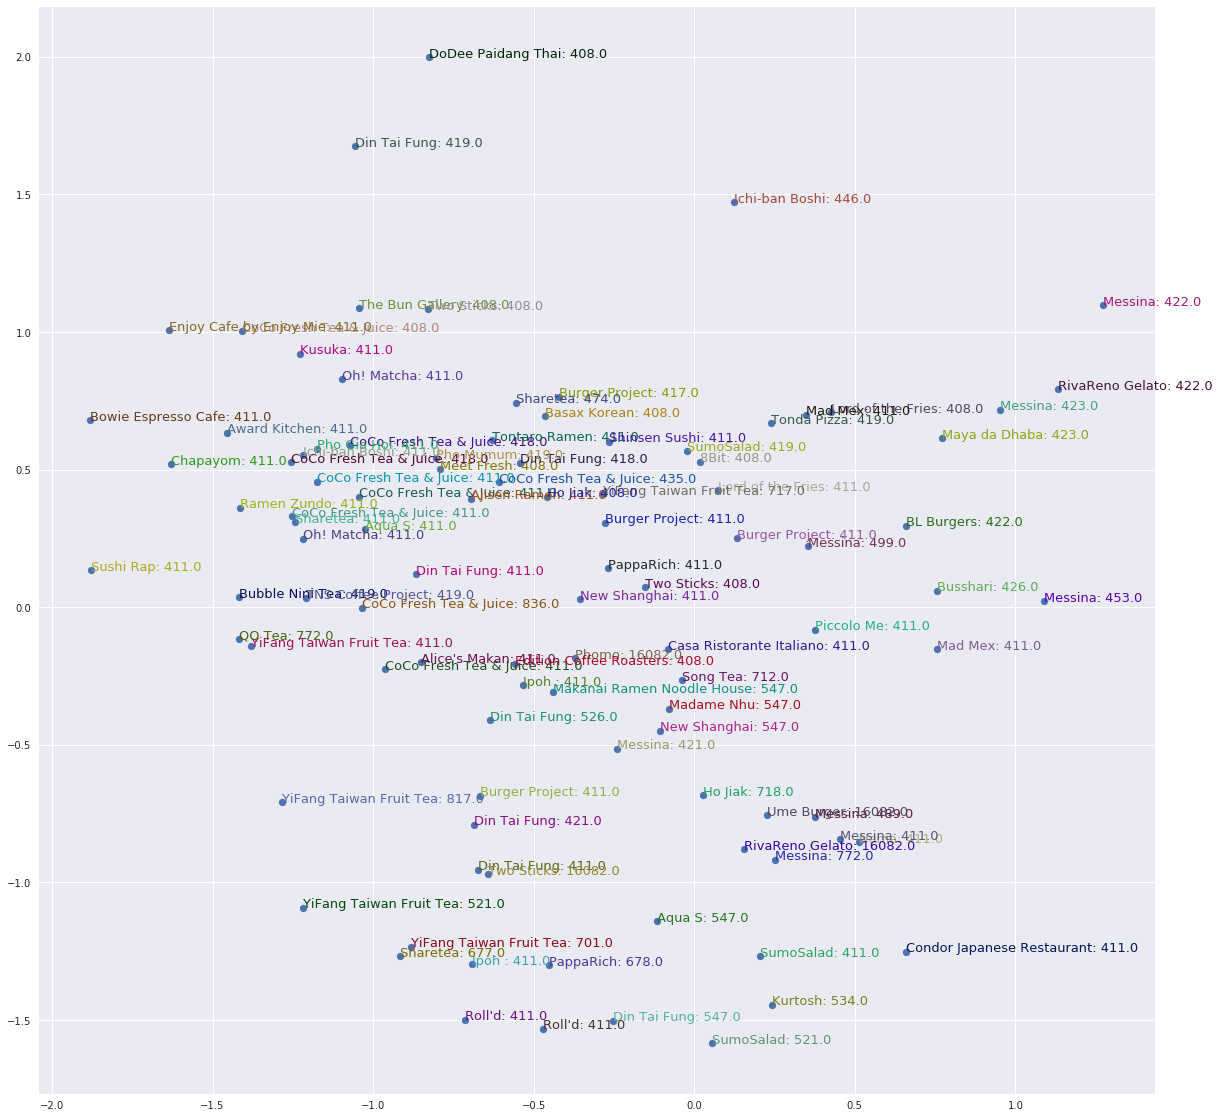

In [135]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

X=pc.x.values
Y=pc.y.values

n=100
idxs = range(n)

plt.figure(figsize=(20,20))
plt.scatter(X[:n], Y[:n])
for i, x, y in zip(itemlist[:n], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=13)
plt.show()

In [133]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [103]:
pca = PCA(n_components=3)
pc = pd.DataFrame(pca.fit_transform(learned[1].data),columns=['x','y','z'])

In [104]:
n=len(city_data.branchId.unique())
n=50

X = pc.x.values[:n]
Y = pc.y.values[:n]
Z = pc.z.values[:n]

trace1 = go.Scatter3d(
    x=X,
    y=Y,
    z=Z,
    mode='markers+text',
    text=[i for i in itemlist[:n]],
    marker=dict(
        size=12,
        color=X,
        colorscale='Viridis',
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='simple-3d-scatter')